In [36]:
# import libraries

import torch
import numpy as np
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from lib_model_summary import summary
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import numpy as np 
import math

import shutil
import os
import time
import sys
from pathlib import Path
import functools

# from lib_util import *

from collections import Counter
print = functools.partial(print, flush=True)

# For 4*4, 16->4->2: batch_size=32; init_lr=0.01; with_norm=True or False
# For 4*4, 16->4->1: batch_size=16; init_lr=0.1; with_norm=True, ang:20; or train

# interest_num = [0,1,2,3,4,5,6,7,8,9]
# how many samples per batch to load
batch_size = 32
inference_batch_size = 32
num_f1 = 1
# num_f2 = len(interest_num)
num_f2 = 2
num_f3 = 2
init_lr = 0.1
init_qc_lr = 1
with_norm = True

# Given_ang to -1 to train the variable 
given_ang = -1
milestones = [6, 10, 14]

save_to_file = False
if save_to_file:
    sys.stdout = open(save_path+"/log", 'w')

# resume_path = "././model/ipykernel_launcher.py_2020_05_04-10_08_35/checkpoint_5_0.9401.pth.tar"
resume_path = "././model/ipykernel_launcher.py_2020_05_04-13_52_53/checkpoint_0_0.9714.pth.tar"
resume_path = "././model/ipykernel_launcher.py_2020_05_04-14_22_13/checkpoint_0_0.9714.pth.tar"
resume_path = "././model/ipykernel_launcher.py_2020_05_05-20_06_18/checkpoint_1_1.0.pth.tar"
# resume_path = ""
save_chkp = 0
training = 1
print_detail = 0
max_epoch = 3

criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()


if save_chkp:
    save_path = "./model/"+os.path.basename(sys.argv[0])+"_"+time.strftime("%Y_%m_%d-%H_%M_%S")
    Path(save_path).mkdir(parents=True, exist_ok=True)


print("="*100)
print("Training procedure for Quantum Computer:")
print("\tStart at:",time.strftime("%m/%d/%Y %H:%M:%S"))
print("\tProblems and issues, please contact Dr. Weiwen Jiang (wjiang2@nd.edu)")
print("\tEnjoy and Good Luck!")
print("="*100)
print()

Training procedure for Quantum Computer:
	Start at: 08/12/2020 02:25:39
	Problems and issues, please contact Dr. Weiwen Jiang (wjiang2@nd.edu)
	Enjoy and Good Luck!



1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 
1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 
1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 
1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 
1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 


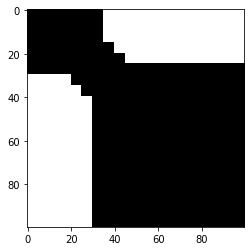

In [37]:
input = []
output = []
i_dim = 20
j_dim = 20
ori_out = [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,
           1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,
           1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,
           1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,
           1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,
           1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
           0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1]


# 
# ori_out = [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]

# ori_out = [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,
#            1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,
#            1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,
#            0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1]

# ori_out = [1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1]


# 1 layer 2 neural
# ori_out = [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1]
# ori_out = torch.tensor(list(torch.empty(20, 20).random_(2).flatten().type(torch.int).tolist()))




golden_data = {}
for i in range(i_dim):
    for j in range(j_dim):
        # if i==0 and j==0:
        #     input.append([0.1*i+0.0001,0.1*j+0.0001])
        
        input.append([(1.0/i_dim)*(i+1),(1.0/j_dim)*(j+1)])
        # if i > j or i>j_dim-j:
        # # if i > j:
        #     output.append([0])
        # else:
        #     output.append([1])
        output.append(ori_out[i*j_dim+j])
        golden_data[tuple([(1.0/i_dim)*(i+1),(1.0/j_dim)*(j+1)])] = ori_out[i*j_dim+j]

for i in range(i_dim):
    for j in range(j_dim):
        print(output[i*j_dim+j],end=" ")
    print()

img = []

for i in range(i_dim):
    row = []    
    for j in range(j_dim):
        # print(input[i*j_https://docs.python.org/3/library/stdtypes.html#listdim+j],end=" ")
        row.append(output[i*j_dim+j])
    img.append(row)
    # print()
    

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
# functions to show an image


def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    img = np.array(img)
    image = np.asarray(img * 255, np.uint8)    
    im = Image.fromarray(image,mode="L")    
    im = im.resize((100,100),Image.NEAREST )    
    # im.thumbnail((64, 64), Image.ANTIALIAS)  # 
    plt.imshow(im,cmap='Greys')
    plt.show()
    # im.save("../results/Figures/example.pdf")



imshow(img)
# print labels
# print(' '.join('%5s' % filtered_class[labels[j]] for j in range(batch_size)))



# sys.exit(0)
dataset_ori = []
for i in range(i_dim):
    for j in range(j_dim):
        dataset_ori.append([torch.tensor(input[i*j_dim+j]),torch.tensor(output[i*j_dim+j])])
        

import random
def batch_generator(dataset,batch_size):
    batch_dataset = []
    for i in range(int(len(dataset)/batch_size)):
        batch = torch.zeros((batch_size,2))        
        batch_target = torch.zeros((batch_size,1),dtype=torch.long)
        for j in range(batch_size):
            item = dataset[i*batch_size+j]            
            batch[j] = item[0]
            batch_target[j] = item[1]
            
        batch_dataset.append((batch,batch_target))
        
    return batch_dataset

dataset = batch_generator(dataset_ori,batch_size)
# dataset = torch.tensor(dataset)
        

def save_checkpoint(state, is_best, save_path, filename):
    filename = os.path.join(save_path, filename)
    torch.save(state, filename)
    if is_best:
        bestname = os.path.join(save_path, 'model_best.tar')
        shutil.copyfile(filename, bestname)




In [38]:

from torch.nn.parameter import Parameter
 

class BinarizeF(Function):

    @staticmethod
    def forward(cxt, input):
        output = input.new(input.size())
        output[input >= 0] = 1
        output[input < 0] = -1


        return output

    @staticmethod
    def backward(cxt, grad_output):
        grad_input = grad_output.clone()
        return grad_input
# aliases
binarize = BinarizeF.apply


class ClipF(Function):

    @staticmethod
    def forward(ctx, input):
        output = input.clone().detach()
        # output = input.new(input.size())
        output[input >= 1] = 1
        output[input <= 0] = 0
        ctx.save_for_backward(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input >= 1] = 0
        grad_input[input <= 0] = 0
        return grad_input


# aliases
clipfunc = ClipF.apply


class BinaryLinear(nn.Linear):


    def do_slp_via_th(self,input_ori,w_ori):
        p = input_ori
        d = 4*p*(1-p)
        e = (2*p-1)
        # e_sq = torch.tensor(1)
        w = w_ori

        sum_of_sq = (d+e.pow(2)).sum(-1)
        sum_of_sq = sum_of_sq.unsqueeze(-1)        
        sum_of_sq = sum_of_sq.expand(p.shape[0], w.shape[0])

        diag_p = torch.diag_embed(e)        

        p_w = torch.matmul(w,diag_p)

        z_p_w = torch.zeros_like(p_w)        
        shft_p_w = torch.cat((p_w, z_p_w), -1)

        sum_of_cross = torch.zeros_like(p_w)
        length = p.shape[1]    

        for shft in range(1,length):    
            sum_of_cross += shft_p_w[:,:,0:length]*shft_p_w[:,:,shft:length+shft]

        sum_of_cross = sum_of_cross.sum(-1)

        return (sum_of_sq+2*sum_of_cross)/(length**2) 

    def forward(self, input):        
        binary_weight = binarize(self.weight)        
        if self.bias is None:
            return self.do_slp_via_th(input,binary_weight)

        else:   

            bias_one  = torch.ones(input.shape[0],1)            
            new_input = torch.cat((input, bias_one), -1)            
            bias = clipfunc(self.bias).unsqueeze(1)            
            new_weight = binary_weight            
            new_weight = torch.cat((new_weight,bias),-1)                        
            return self.do_slp_via_th(new_input,new_weight)


            torch.set_printoptions(edgeitems=64)
            # binary_bias = binarize(self.bias)/float(len(input[0].flatten())+1)
            binary_bias = binarize(self.bias)/float(len(input[0].flatten())+1)
            res = F.linear(input, binary_weight/float(len(input[0].flatten())+1), binary_bias)
            return res

    def reset_parameters(self):
        # Glorot initialization
        in_features, out_features = self.weight.size()
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv





class QC_Norm(nn.Module):
    def __init__(self, num_features, init_ang_inc = 10, momentum=0.1):        
        super(QC_Norm, self).__init__()
        
        self.x_running_rot = Parameter(torch.zeros(num_features),requires_grad=False)        
        self.ang_inc = Parameter(torch.ones(1)*init_ang_inc)
        
        self.momentum = momentum
                
        self.printed = False
        self.x_mean_ancle=0
        self.x_mean_rote = 0
        self.input = 0
        self.output = 0
        
    def forward(self,x,training=True):  
        if not training:
            if not self.printed:
                print("self.ang_inc",self.ang_inc)
                self.printed = True
                    
            x = x.transpose(0,1)
  
            x_ancle = (x*2-1).acos()
            x_final = x_ancle+self.x_running_rot.unsqueeze(-1)
            x_1 = (x_final.cos()+1)/2
                                
            x_1 = x_1.transpose(0,1)
            # print(x_1)
        else:
            self.printed = False
            x = x.transpose(0,1)        
            x_sum = x.sum(-1).unsqueeze(-1).expand(x.shape)
            x_lack_sum = x_sum - x    
            x_mean = x_lack_sum/x.shape[-1]
            
            # print(x)
            # print(x_sum)
            # print(x_lack_sum)
            # print(x_mean)
            # 
                    
            x_mean_ancle = (x_mean*2-1).acos()  
            
            ang_inc = self.ang_inc.unsqueeze(-1).expand(x_mean_ancle.shape) 
            # ang_inc = np.pi/2/(x.max(-1)[0].unsqueeze(-1).expand(x_mean_ancle.shape) -x.min(-1)[0].unsqueeze(-1).expand(x_mean_ancle.shape) )
            
            if given_ang!=-1:
                x_mean_rote = (np.pi/2 - x_mean_ancle)*given_ang
            else:
                x_mean_rote = (np.pi/2 - x_mean_ancle)*ang_inc
            
            x_moving_rot = (x_mean_rote.sum(-1)/x.shape[-1])            
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * x_moving_rot
                                                
            x_ancle = (x*2-1).acos()
            x_final = x_ancle+x_mean_rote  
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
      
        return x_1
    
    def reset_parameters(self):
        self.reset_running_stats()
        self.ang_inc.data.zeros_()
        
def print_degree(x,name="x"):
    print(name,x/np.pi*180)
    
    
class QC_Norm_Real(nn.Module):
    def __init__(self,num_features,momentum=0.1):        
        super(QC_Norm_Real, self).__init__()        
        self.x_running_rot = Parameter(torch.zeros(num_features),requires_grad=False)
        self.momentum = momentum
        
        self.x_max = 0
        self.x_min = 0
        # print("Using Normal without real")
        
        
    def forward(self,x,training=True):  
        if not training:
            x = x.transpose(0,1)
            
            x_ancle = (x*2-1).acos()
            # x_final = x_ancle+self.x_running_rot.unsqueeze(-1)  
            x_final = ((x_ancle-self.x_min)/(self.x_max-self.x_min))*np.pi
            
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
            
        else:
            
            x = x.transpose(0,1)        
            x_ancle = (x*2-1).acos()     
            x_rectify_ancle = (x_ancle.max(-1)[0]-x_ancle.min(-1)[0]).unsqueeze(-1).expand(x.shape)                                                                         
            x_final = ((x_ancle-x_ancle.min(-1)[0].unsqueeze(-1))/(x_rectify_ancle))*np.pi
            
            x_moving_rot = x_final - x_ancle
            
            x_moving_rot_mean = x_moving_rot.sum(-1)/x.shape[-1] 
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * x_moving_rot_mean      
            
            self.x_max = self.momentum * x_ancle.max(-1)[0].unsqueeze(-1) + \
                                    (1 - self.momentum) * self.x_max
            self.x_min = self.momentum * x_ancle.min(-1)[0].unsqueeze(-1) + \
                                    (1 - self.momentum) * self.x_min
            
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
            
            
        return x_1


class QC_Norm_Real_Correction(nn.Module):
    def __init__(self,num_features,momentum=0.1):        
        super(QC_Norm_Real_Correction, self).__init__()        
        self.x_running_rot = Parameter(torch.zeros(num_features),requires_grad=False)
        self.momentum = momentum
        
    def forward(self,x,training=True):  
        if not training:
            x = x.transpose(0,1)
            
            x_ancle = (x*2-1).acos()
            x_final = x_ancle+self.x_running_rot.unsqueeze(-1)  
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
            
        else:            
            
            x = x.transpose(0,1)                    
            x_ancle = (x*2-1).acos()                        
            x_moving_rot = -1*(x_ancle.min(-1)[0])
            
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * x_moving_rot                                                    
            x_final = x_ancle+x_moving_rot.unsqueeze(-1)                                    
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
            
            
        
        return x_1

class QC_Norm_Correction(nn.Module):
    def __init__(self,num_features,momentum=0.1):        
        super(QC_Norm_Correction, self).__init__()        
        self.x_running_rot = Parameter(torch.zeros(num_features),requires_grad=False)
        self.momentum = momentum
        
    def forward(self,x,training=True):  
        if not training:
            x = x.transpose(0,1)
            
            x_ancle = (x*2-1).acos()
            x_final = x_ancle+self.x_running_rot.unsqueeze(-1)  
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
            
        else:
            x = x.transpose(0,1)        
            x_sum = x.sum(-1).unsqueeze(-1).expand(x.shape)                
            x_mean = x_sum/x.shape[-1]
                                
            x_mean_ancle = (x_mean*2-1).acos()    
            x_mean_rote = (np.pi/2 - x_mean_ancle) 
            
            x_moving_rot = (x_mean_rote.sum(-1)/x.shape[-1])
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * x_moving_rot                                        
            x_ancle = (x*2-1).acos()
            x_final = x_ancle+x_mean_rote  
            x_1 = (x_final.cos()+1)/2                                
            x_1 = x_1.transpose(0,1)
        
        return x_1
    
    
    



class QC_Norm_True(nn.Module):
    def __init__(self,num_features):        
        super(QC_Norm_True, self).__init__()
        
        x_r_init =  torch.zeros(num_features)
        x_r_init += 0
        
        self.x_qft = Parameter(torch.zeros(num_features),requires_grad=True)
        self.x_hzh = Parameter(torch.zeros(num_features),requires_grad=True)
        
        self.x_running_rot = Parameter(x_r_init,requires_grad=True)
        
        self.x_running_means = Parameter(torch.zeros(num_features),requires_grad=False)
        self.x_running_min = Parameter(torch.zeros(num_features),requires_grad=False)
        self.x_running_max = Parameter(torch.zeros(num_features),requires_grad=False)
        
        self.printed = False
        self.momentum = 0.1
    def forward(self,x,training=True):
        if not training:
            if not self.printed:
                # print(self.x_qft)
                # print(self.x_hzh)
                print(self.x_running_rot)

                # print(((binarize(self.x_qft)+1)/2)*0.5)
                # print(((binarize(self.x_qft)+1)/2)*0.5*x)
                # print(((1-x)-x)*self.x_running_rot + x)
                self.printed = True
            x_min_rt = self.x_running_min.detach()
            x_max_rt = self.x_running_max.detach()
        else:
            self.printed = False           
            # x_running_rot = self.x_running_rot    
            x = x.transpose(0,1)
            # x_sum = x.sum(-1)
            # x_mean = x_sum/x.shape[-1]
            x_min = x.min(1)[0]
            x_max = x.max(1)[0]            
            x = x.transpose(0,1)
            self.x_running_min[:] = self.momentum * self.x_running_min + \
                                (1 - self.momentum) * x_min 
            self.x_running_max[:] = self.momentum * self.x_running_max + \
                                (1 - self.momentum) * x_max
            x_min_rt = x_min
            x_max_rt = x_max
        
        x = (x_min_rt*(1-2*x)+x)
            
        # x = x+x-2*x*x
        
        # ry
        # init_rot = (x<0.5).float()*np.pi        
        # final_rot = init_rot + self.x_running_rot                 
        # r = (2*x-1).abs()        
        # x = (r*final_rot.cos()+1)/2 
        
        return x
        # QFT
        # 
        # qft_g_10 = (binarize(self.x_qft-10)+1)/2
        # qft_g_5 = (binarize(self.x_qft-5)+1)/2 - qft_g_10
        # qft_g_0 = (binarize(self.x_qft-0)+1)/2 - qft_g_5 - qft_g_10
        # x = qft_g_10*0.038*x + (1-qft_g_10)*x
        # x = qft_g_5*0.146*x + (1-qft_g_5)*x
        # x = qft_g_0*0.5*x + (1-qft_g_0)*x
        
        # x = ((binarize(self.x_qft)+1)/2*0.5)*x
        # x = (((binarize(self.x_qft-5)+1)/2 - (binarize(self.x_qft-10)+1)/2)*0.146)*x
        # x = (((binarize(self.x_qft-0)+1)/2 - (binarize(self.x_qft-5)+1)/2 - (binarize(self.x_qft-10)+1)/2)*0.5)*x
        
        
        # x = (x+(binarize(self.x_hzh)+1)/2*(1-2*x))
        # 
        # x = (((binarize(self.x_qft)+1)/2)*0.5)*x + (((1-(binarize(self.x_qft)+1)/2))*1)*x 
        # x = (((binarize(self.x_qft-10)+1)/2)*0.1)*x + (((1-(binarize(self.x_qft-10)+1)/2))*1)*x
        # 
        # # hzh <- y
        # x = ((1-x)-x)*clipfunc(self.x_hzh) + x        
        # 
        # 
        # # ry
        # init_rot = (x<0.5).float()*np.pi        
        # final_rot = init_rot + self.x_running_rot                 
        # r = (2*x-1).abs()        
        # x1 = (r*final_rot.cos()+1)/2   


            
        # if not training:
        #     
        #     # init_rot = (x<0.5).float()*np.pi        
        #     # final_rot = init_rot + self.x_running_rot                 
        #     # r = (2*x-1).abs()        
        #     # x = (r*final_rot.cos()+1)/2   
        #     # 
        #     # x = 1-(x+self.x_running_means-2*x*self.x_running_means)
        #     # x = (1-x)/2
        #     # x = self.x_running_means*(1-2*x)+x
        #     # 
        #     # if not self.printed:
        #     #     print("self.x_running_means",self.x_running_means)
        #     #     self.printed = True
        #     #     # print(x)
        #     return x
        # 
        # else:
        #     self.printed = False
            
            # # ry
            # init_rot = (x<0.5).float()*np.pi        
            # final_rot = init_rot + self.x_running_rot                 
            # r = (2*x-1).abs()        
            # x = (r*final_rot.cos()+1)/2   

            
            
            # x = x.transpose(0,1)
            # x_sum = x.sum(-1)
            # 
            # # self.x_running_rot = self.x_running_rot.clamp(0,1) 
            # 
            # x_mean = x_sum/x.shape[-1]
            # 
            #          
            # #          *self.x_hzh+self.x_running_rot/10
            # # x_mean = x_mean.clamp(0,1)        
            # x = x.transpose(0,1)
            #     
            
            
        #     return x
        #     
        #     
        #     sys.exit(0)
        #     x_sum = x.sum(-1).unsqueeze(-1).expand(x.shape)
        #     x_lack_sum = x_sum - x    
        #     x_mean = x_lack_sum/x.shape[-1]
        #     
        #     
        #             
        #     x_mean_ancle = (x_mean*2-1).acos()  
        #     
        #     ang_inc = self.ang_inc.unsqueeze(-1).expand(x_mean_ancle.shape) 
        #     # ang_inc = np.pi/2/(x.max(-1)[0].unsqueeze(-1).expand(x_mean_ancle.shape) -x.min(-1)[0].unsqueeze(-1).expand(x_mean_ancle.shape) )
        #     
        #     if given_ang!=-1:
        #         x_mean_rote = (np.pi/2 - x_mean_ancle)*given_ang
        #     else:
        #         x_mean_rote = (np.pi/2 - x_mean_ancle)*ang_inc
        #     
        #     x_moving_rot = (x_mean_rote.sum(-1)/x.shape[-1])            
        #     self.x_running_rot[:] = self.momentum * self.x_running_rot + \
        #                           (1 - self.momentum) * x_moving_rot
        #                                         
        #     x_ancle = (x*2-1).acos()
        #     x_final = x_ancle+x_mean_rote  
        #     x_1 = (x_final.cos()+1)/2                                
        #     x_1 = x_1.transpose(0,1)
        # return x






class QC_Norm_try2(nn.Module):
    def __init__(self, num_features, batch_size=32, init_ang_inc = 0, momentum=0.1):        
        super(QC_Norm_try2, self).__init__()
        
        self.x_running_rot = Parameter(torch.zeros((num_features,batch_size)),requires_grad=False)        
        self.ang_inc = Parameter(torch.ones(1)*init_ang_inc)
        
        self.momentum = momentum
                
        self.printed = False
        self.x_mean_ancle=0
        self.x_mean_rote = 0
        self.input = 0
        self.output = 0
        
        
    def forward(self,x,training=True):  
        if not training:
            if not self.printed:
                print("self.x_running_rot",self.x_running_rot)
                self.printed = True
                    
            x = x.transpose(0,1)
            x_1  = (self.x_running_rot*(1-x)+x)  
            x_1 = x_1.transpose(0,1) 
            # x_ancle = (x*2-1).acos()
            # x_final = x_ancle+self.x_running_rot.unsqueeze(-1)
            # x_1 = (x_final.cos()+1)/2
            #                     
            # x_1 = x_1.transpose(0,1)
            # print(x_1)
        else:
            self.printed = False
            x = x.transpose(0,1)        
            x_sum = x.sum(-1).unsqueeze(-1).expand(x.shape)
            x_lack_sum = x_sum - x    
            x_mean = x_lack_sum/x.shape[-1]
            
            
                                  
            # ang_inc = self.ang_inc.unsqueeze(-1).expand(x.shape)    
            
            y  = ((0.5-x_mean)/(1-x_mean))
            # y = clipfunc(y)
            
            # print(y)
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * y

            # self.x_running_rot[:] = y
            
            x_1  = (y*(1-x)+x)
            x_1 = x_1.transpose(0,1) 
            # x_1  = (y*(1-x)+x)
            # sys.exit(0)
            # 
            # 
            # x_mean_ancle = (x_mean*2-1).acos()
            # ang_inc = self.ang_inc.unsqueeze(-1).expand(x_mean_ancle.shape)             
            # 
            # if given_ang!=-1:
            #     x_mean_rote = (np.pi/2 - x_mean_ancle)*given_ang
            # else:
            #     x_mean_rote = (np.pi/2 - x_mean_ancle)*ang_inc
            # 
            # x_moving_rot = (x_mean_rote.sum(-1)/x.shape[-1])            
            # self.x_running_rot[:] = self.momentum * self.x_running_rot + \
            #                       (1 - self.momentum) * x_moving_rot
            #                                     
            # x_ancle = (x*2-1).acos()
            # x_final = x_ancle+x_mean_rote  
            # x_1 = (x_final.cos()+1)/2                                
            # x_1 = x_1.transpose(0,1)
      
        return x_1
    
    def reset_parameters(self):
        self.reset_running_stats()
        self.ang_inc.data.zeros_()


class QC_Norm_try3(nn.Module):
    def __init__(self, num_features, batch_size=32, init_ang_inc = 1, momentum=0.1):        
        super(QC_Norm_try3, self).__init__()
        
        self.x_running_rot = Parameter(torch.zeros((num_features)),requires_grad=False)        
        # self.ang_inc = Parameter(torch.ones((num_features)),requires_grad=True)
        self.ang_inc = Parameter(torch.tensor(init_ang_inc,dtype=torch.float32),requires_grad=True)        
        self.momentum = momentum
                
        self.printed = False
        self.x_mean_ancle=0
        self.x_mean_rote = 0
        self.input = 0
        self.output = 0
        
        
    def forward(self,x,training=True):  
        if not training:
            if not self.printed:
                # print("self.ang_inc",self.ang_inc)
                self.printed = True                            
            x_1  = (self.x_running_rot*x)               
     
        else:
            self.printed = False
            x = x.transpose(0,1)        
            x_sum = x.sum(-1).unsqueeze(-1).expand(x.shape)
            x_lack_sum = x_sum + x    
            x_mean = x_lack_sum/x.shape[-1]                    
            
            
            
            ang_inc = (self.ang_inc>0).float()*self.ang_inc+1
            # ang_inc = self.ang_inc.abs()+1
            # ang_inc = 2
            y  = 0.5/x_mean
            y = y.transpose(0,1)
            y = y/ang_inc
            y = y.transpose(0,1)
    
            x_moving_rot = (y.sum(-1)/x.shape[-1]) 
            
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * x_moving_rot
            
            x_1  = y*x
            x_1 = x_1.transpose(0,1) 
            
        return x_1
    
    def reset_parameters(self):
        self.reset_running_stats()
        self.ang_inc.data.zeros_()



class QC_Norm_Correction_try2(nn.Module):
    def __init__(self,num_features,momentum=0.1):        
        super(QC_Norm_Correction_try2, self).__init__()        
        self.x_running_rot = Parameter(torch.zeros(num_features),requires_grad=False)
        self.momentum = momentum
        self.x_l_0_5 = Parameter(torch.zeros(num_features),requires_grad=False)
        self.x_g_0_5 = Parameter(torch.zeros(num_features),requires_grad=False)
        
    def forward(self,x,training=True):  
        if not training:            
            x_1  = self.x_l_0_5*(self.x_running_rot*(1-x)+x)
            x_1 += self.x_g_0_5*(self.x_running_rot*x)            
        else:
            x = x.transpose(0,1)        
            x_sum = x.sum(-1)            
            x_mean = x_sum/x.shape[-1]
            
            
            
            self.x_l_0_5[:] = ((x_mean<=0.5).float())
            self.x_g_0_5[:] = ((x_mean>0.5).float())
            
            y  = self.x_l_0_5*((0.5-x_mean)/(1-x_mean))
            y += self.x_g_0_5*(0.5/x_mean)
            
            self.x_running_rot[:] = self.momentum * self.x_running_rot + \
                                  (1 - self.momentum) * y
            
            
            x = x.transpose(0,1)  
            x_1  = self.x_l_0_5*(y*(1-x)+x)
            x_1 += self.x_g_0_5*(y*x)
            
        return x_1
    

class BinaryLinearClassic(nn.Linear):

    def forward(self, input):
        binary_weight = binarize(self.weight)
        if self.bias is None:
            output = F.linear(input, binary_weight)
            output = torch.div(output, input.shape[-1])
            output = torch.pow(output, 2)

            return output
        else:
            print("Not Implement")
            sys.exit(0)

    def reset_parameters(self):
        # Glorot initialization
        in_features, out_features = self.weight.size()
        stdv = math.sqrt(1.5 / (in_features + out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

        self.weight.lr_scale = 1. / stdv



## Define the NN architecture
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
        
        
        
        self.fc1 = BinaryLinear(2,num_f1,bias=False)
        self.fc2 = BinaryLinear(num_f1,num_f2,bias=False)
        # self.fc3 = BinaryLinear(num_f2,num_f3,bias=False)
        # # # 
        # 
        # # if not with_norm or True:
        # self.clc_fc1 = BinaryLinearClassic(in_features=2, out_features=num_f1, bias=False)            
        # self.clc_fc2 = BinaryLinearClassic(in_features=num_f1, out_features=num_f2, bias=False)
        # self.clc_fc3 = BinaryLinearClassic(in_features=num_f2, out_features=num_f3, bias=False)
        # 
        # 
        # self.clc_bn1 = nn.BatchNorm1d(num_features=num_f1)
        # self.clc_bn2 = nn.BatchNorm1d(num_features=num_f2)
        if with_norm:
            self.qc1 = QC_Norm_try3(num_features=num_f1,init_ang_inc=[1])
            self.qc2 = QC_Norm_try3(num_features=num_f2,init_ang_inc=[1,1])
            # self.qc3 = QC_Norm(num_features=num_f3)
    
            # self.qc1a = QC_Norm_True(num_features=num_f1)
            # self.qc2a = QC_Norm_True(num_features=num_f2)
            # self.qc3a = QC_Norm_Correction(num_features=num_f3)
            
            self.qc1a = QC_Norm_Correction_try2(num_features=num_f1)
            self.qc2a = QC_Norm_Correction_try2(num_features=num_f2)
            
            # 
            # self.qc1 = QC_Norm_Real(num_features=num_f1)
            # self.qc2 = QC_Norm_Real(num_features=num_f2)
            # self.qc3 = QC_Norm_Real(num_features=num_f3)


        # self.qc1a = QC_Norm_Real_Correction(num_features=num_f1)
        # self.qc2a = QC_Norm_Real_Correction(num_features=num_f2)
        # self.qc3a = QC_Norm_Real_Correction(num_features=num_f3)
        # 
    def forward(self, x, training=1):        
        x = x.view(-1, 2)
        
        if training == 1:
            # x = binarize(x-0.0001)
            # x = (x+1)/2
            # 
            

            if with_norm:
                # x = self.qc1a(self.fc1(x))                
                # x = self.qc2a(self.fc2(x))
                                                
                
                x = self.qc1(self.qc1a(self.fc1(x)))
                x = (self.qc2a(self.fc2(x)))
                
                
                
                
                # print(x)
                # x = self.fc1(x)
                # print(x)
                # x = self.qc1a(x)
                # print(x)
                # x = self.qc1(x)
                # print(x)
                # 
                # print(x)
                # x = self.fc2(x)
                # print(x)
                # x = self.qc2a(x)
                # print(x)
                # x = self.qc2(x)
                # print(x)
                
                # print(x)
                # sys.exit(0)
            else:
                x = self.clc_fc1(x)        
                x = self.clc_fc2(x)
                # x = self.clc_fc3(x)  

            # x = self.qc3(self.qc3a(self.fc3(x)))
            # 
            # x = self.qc1((self.fc1(x)))        
            # x = self.qc2((self.fc2(x)))                           
            # x = self.qc3((self.fc3(x)))
            # 
        elif training == 2:
            
            # x = binarize(x-0.0001)
            # x = (x+1)/2
            
            print("="*10,"layer 1","="*10)
            print(x)
            torch.set_printoptions(profile="full")            
            print(binarize(self.fc1.weight))                                            
            torch.set_printoptions(profile="default")
            x = self.fc1(x)            
            
            print("="*10,"layer 2","="*10)
            print(x)
            torch.set_printoptions(profile="full")            
            print(binarize(self.fc2.weight))                                            
            torch.set_printoptions(profile="default")
            x = self.fc2(x)
            
            print("="*10,"results","="*10)
            print(x)
            
            
        else:
            
            # x = self.qc1(self.fc1(x),training=False)
            #     x = self.qc2(self.fc2(x),training=False)
            # x = self.qc3(self.fc3(x),training=False)
            # 
            
            # x = binarize(x-0.0001)
            # x = (x+1)/2
            # 
            # x = self.qc3(self.qc3a(self.fc3(x),training=False),training=False)
            
            if with_norm:                
                if not print_detail:
                    x = self.qc1(self.qc1a(self.fc1(x),training=False),training=False)                
                    x = (self.qc2a(self.fc2(x),training=False))
                else:
                    print(x)
                    x = self.fc1(x)
                    print(x)
                    x = self.qc1a(x,training=False)
                    print(x)
                    x = self.qc1(x,training=False)
                    print(x)
    
                    print(x)
                    x = self.fc2(x)
                    print(x)
                    x = self.qc2a(x,training=False)
                    print(x)
                    # x = self.qc2(x,training=False)
                    print(x)
                    # 
                    # x = self.qc1a(self.fc1(x),training=False)                
                    # x = self.qc2a(self.fc2(x),training=False)                                        
            else:
                x = self.clc_fc1(x)                    
                x = self.clc_fc2(x)
                # x = self.clc_fc3(x)  
            
        if num_f2==1 or num_f1==1:            
            x = torch.cat((x,1-x),-1)
            
        return x




def train(epoch):
    model.train()
    correct = 0
    epoch_loss = []
    batch_idx = 0
    for (data, target) in dataset:
        
        
        target = target.view(batch_size)
        
        
        
        
        # target,new_target = modify_target(target)
        # 
        # data = (data-data.min())/(data.max()-data.min())
        # data = (binarize(data-0.5)+1)/2
        # 
        
        
        
        data, target = data.to(device), target.to(device)        
        optimizer.zero_grad()
        output = model(data,True)
        
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability

        
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()    
        
        # print(output.shape,target.shape)
        
        # sys.exit(0)
        
        loss = criterion(output, target)
        epoch_loss.append(loss.item())
        loss.backward()
        
        optimizer.step()
                
        if batch_idx % 20 == 0:        
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}/{} ({:.2f}%)'.format(
                epoch, batch_idx * len(data), len(dataset),
                100. * batch_idx / len(dataset), loss, correct, (batch_idx+1) * len(data),
                100. * float(correct) / float(((batch_idx+1) * len(data)) )))                
        batch_idx += 1
    print("-"*20,"training done, loss","-"*20)
    print("Training Set: Average loss: {}".format(round(sum(epoch_loss)/len(epoch_loss),6)))
    
accur=[]
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataset:
        # target,new_target = modify_target(target)
        target = target.view(batch_size)
        # 
        # data = (data-data.min())/(data.max()-data.min())
        # data = (binarize(data-0.5)+1)/2
        
        # print("="*100)        
        # print(data)
        
        data, target = data.to(device), target.to(device)
        
        # print("Debug")
        # output = model(data,2)
        # 
        
        # data, target = Variable(data, volatile=True), Variable(target)
        output = model(data,False)
        
        # 
        test_loss += criterion(output, target) # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get t
        # print(pred.view(batch_size))# he index of the max log-probability
        # print(target,output)
        # sys.exit(0)
        # print(pred.eq(target.data.view_as(pred)).cpu().sum())
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    a=100.*correct / len(dataset)*batch_size
    accur.append(a)  
    test_loss /= len(dataset)*batch_size
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(dataset)*batch_size,
        100. * float(correct) / float(len(dataset)*batch_size)))
    
    return float(correct) / (len(dataset)*batch_size)




#Training


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print("="*10,"Model Info","="*10)
print(model)
# summary(model,(1,img_size,img_size))

# 
# # optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)
if with_norm and given_ang==-1:
    optimizer = torch.optim.Adam([
                    {'params': model.fc1.parameters()},
                    # {'params': model.fc2.parameters()},
                    # {'params': model.fc3.parameters()},
                    {'params': model.qc1.parameters(), 'lr': init_qc_lr},
                    # {'params': model.qc2.parameters(), 'lr': init_qc_lr},
                    # {'params': model.qc3.parameters(), 'lr': 1},
                ], lr=init_lr)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)



# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# optimizer = torch.optim.SGD([
#                 {'params': model.fc1.parameters()},
#                 {'params': model.fc2.parameters()},
#                 {'params': model.fc3.parameters()},
#                 {'params': model.qc1.parameters(), 'lr': 1},
#                 {'params': model.qc2.parameters(), 'lr': 1},
#                 {'params': model.qc3.parameters(), 'lr': 1},
#             ], lr=0.1, momentum=0.9)

# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, \
#         base_lr=[1e-1,1e-1,1e-1,1,1,1], \
#         max_lr=[1e-3,1e-3,1e-3,1e-2,1e-2,1e-2], \
#         step_size_up=100
#         )


scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

# 
# 
# test()
# 
# 







if os.path.isfile(resume_path):
    print("=> loading checkpoint from '{}'<=".format(resume_path))
    checkpoint = torch.load(resume_path, map_location=device)
    epoch_init,acc = checkpoint["epoch"],checkpoint["acc"]
    model.load_state_dict(checkpoint["state_dict"])
    
    
    
    scheduler.load_state_dict(checkpoint["scheduler"])    
    scheduler.milestones = Counter(milestones)
    optimizer.load_state_dict(checkpoint["optimizer"])
else:
    epoch_init,acc = 0,0

# for name,para in model.named_parameters():
#     print(name,para)

# sys.exit(0)
import copy
best_model = -1
acc= 0
if training:
    for epoch in range(epoch_init, max_epoch + 1):
        print("="*20,epoch,"epoch","="*20)  
        print("Epoch Start at:",time.strftime("%m/%d/%Y %H:%M:%S"))        

        print("-"*20,"learning rates","-"*20)
        for param_group in optimizer.param_groups:
            print(param_group['lr'],end=",")
        print()    
        
        print("-"*20,"training","-"*20)
        print("Trainign Start at:",time.strftime("%m/%d/%Y %H:%M:%S"))
        train(epoch)
        print("Trainign End at:",time.strftime("%m/%d/%Y %H:%M:%S"))
        print("-"*60)
        
        print()
        
        
        # 
        # for name,para in model.named_parameters():
        #     print(name,para)
        # 
        print("-"*20,"testing","-"*20)
        print("Testing Start at:",time.strftime("%m/%d/%Y %H:%M:%S"))        
        cur_acc = test()
        print("Testing End at:",time.strftime("%m/%d/%Y %H:%M:%S"))
        print("-"*60)
        print()
        
        scheduler.step()
        
        is_best = False
        if cur_acc > acc:
            is_best = True
            acc=cur_acc
            best_model = copy.deepcopy(model)
            
            
        
        print("Best accuracy: {}; Current accuracy {}. Checkpointing".format(acc,cur_acc))
        if save_chkp:
            save_checkpoint({
              'epoch': epoch + 1,
              'acc': acc, 
              'state_dict': model.state_dict(),      
              'optimizer' : optimizer.state_dict(),
               'scheduler': scheduler.state_dict(),
            }, is_best, save_path, 'checkpoint_{}_{}.pth.tar'.format(epoch,round(cur_acc,4)))
        print("Epoch End at:",time.strftime("%m/%d/%Y %H:%M:%S"))
        print("="*60)
        print()        
else:    
    # print("="*20,epoch,"Testing","="*20)  
    # test_loader = torch.utils.data.DataLoader(test_data, batch_size=inference_batch_size, 
    #     num_workers=num_workers, shuffle=True, drop_last=True)
    # test()



    print("="*100)
    for name,para in model.named_parameters():
        print(name,para)
    print("="*100)


    # output = model(torch.tensor([0.2,0.6]),False)
    # print(output[0][0],output[0][1])
    

    # 
    # # # 
    # # model(torch.tensor([0.95,0.95]),False)
    # sys.exit(0)
    # 
    gap = []
    pair = {}
    for i in range(i_dim):
        for j in range(j_dim):
            input = ([(1.0/i_dim)*(i+1),(1.0/j_dim)*(j+1)])            
            output = model(torch.tensor(input),False)
            gap.append((output[0][0]-output[0][1]).data)
            pair[tuple(input)] = [output[0][0],output[0][1]]
            # print(input,output.data,(output[0][0]-output[0][1]).data)
    
    
    # for k,v in pair.items():        
    #     # if abs(v[0]-v[1]) in torch.tensor(gap).abs().topk(70)[0]: #and golden_data[k]==1:
    #     print((v[0].data-v[1].data).abs(),v[0].data,v[1].data,golden_data[k],k)
    # sys.exit(0)


if training:
    print("="*100)
    for name,para in best_model.named_parameters():
        print(name,para)
    print("="*100) 
    for i in range(i_dim):
        for j in range(j_dim):
            data = dataset_ori[i*j_dim+j][0]
            output = model(data,False)
    
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            print(pred.data.item(),end = " ")
        print()
    
    for i in range(i_dim):
        for j in range(j_dim):
            data = dataset_ori[i*j_dim+j][0]
            output = model(data,False)
    
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            print(pred.data.item(),end = ",")
    print()     

sys.exit(0)

========== Model Info ==========
Net(
  (fc1): BinaryLinear(in_features=2, out_features=1, bias=False)
  (fc2): BinaryLinear(in_features=1, out_features=2, bias=False)
  (qc1): QC_Norm_try3()
  (qc2): QC_Norm_try3()
  (qc1a): QC_Norm_Correction_try2()
  (qc2a): QC_Norm_Correction_try2()
)
==================== 0 epoch ====================
Epoch Start at: 08/12/2020 02:25:41
-------------------- learning rates --------------------
0.1,1.0,
-------------------- training --------------------
Trainign Start at: 08/12/2020 02:25:41
Train Epoch: 0 [0/12 (0%)]	Loss: nan	Accuracy: 18/32 (56.25%)
-------------------- training done, loss --------------------
Training Set: Average loss: nan
Trainign End at: 08/12/2020 02:25:41
------------------------------------------------------------

-------------------- testing --------------------
Testing Start at: 08/12/2020 02:25:41
Test set: Average loss: nan, Accuracy: 141/384 (36.72%)
Testing End at: 08/12/2020 02:25:41
---------------------------------

SystemExit: 0

In [ ]:
import torch
print("="*30)
x = 0.95
y = 0.65
print(torch.tensor([((x*(1-y)+y*(1-x))*2)-1]).acos())
# print(torch.tensor([(0.3*2)-1]).acos())
# print(torch.tensor([(0.1*2)-1]).acos())
print("="*30)
print(torch.tensor([1-(0.1393*2)]).acos())
print(torch.tensor([(0.9699*2)-1]).acos())
# print(torch.tensor([(0.8607*0.9699*2)-1]).acos())
# print(torch.tensor([(0.0733*2)-1]).acos())


print("="*10)
print(torch.tensor([1-(0.8*2)]).acos())
print(torch.tensor([1-(0.6*2)]).acos())
print(torch.tensor([1-(0.1*2)]).acos())
print(torch.tensor([1-(0.3*2)]).acos())

x = torch.tensor([0.8,0.8,0.8])
y = torch.tensor([0.6,0.1,0.3])
print((1-((1-x)*y+(1-y)*x)*2).acos())
# 
# print(torch.tensor([1-((0.8*0.4+0.2*0.6)*2)]).acos())




In [ ]:
import sys
sys.path.append("../interfae")
from qiskit_simulator import *



accur=[]
def test_debug():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        target,new_target = modify_target(target)
        
        # 
        # data = (data-data.min())/(data.max()-data.min())
        # data = (binarize(data-0.5)+1)/2
        
        data, target = data.to(device), target.to(device)
        
        # print("Debug",data,target)
        # output = model(data,2)
        # 
        # run_simulator(model,data)
        
        output = model(data,False)
        # print(data)
        # print(output)
        # print(target)
        # sys.exit(0)
        # data, target = Variable(data, volatile=True), Variable(target)
        # output = model(data,False)
        test_loss += criterion(output, target) # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    a=100.*correct / len(test_loader.dataset)
    accur.append(a)  
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * float(correct) / float(len(test_loader.dataset))))
    
    return float(correct) / len(test_loader.dataset)



if os.path.isfile(resume_path):
    print("=> loading checkpoint from '{}'<=".format(resume_path))
    checkpoint = torch.load(resume_path, map_location=device)
    epoch_init,acc = checkpoint["epoch"],checkpoint["acc"]
    model.load_state_dict(checkpoint["state_dict"])
    
    
    
    scheduler.load_state_dict(checkpoint["scheduler"])    
    scheduler.milestones = Counter(milestones)
    optimizer.load_state_dict(checkpoint["optimizer"])
else:
    epoch_init,acc = 0,0

print("HERE")
test_loader = torch.utils.data.DataLoader(test_data, batch_size=inference_batch_size, 
        num_workers=num_workers, shuffle=True, drop_last=True)
test_debug()



In [ ]:
# for name, para in model.named_parameters():
# #     print(name,para)
# print("HERE")